In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.metrics import pairwise_distances
import math
from scipy.stats import pearsonr, spearmanr

In [2]:
# Read in data
T_file = os.path.join('desktop', 'daily_T.csv')
P_file = os.path.join('desktop', 'daily_P.csv')
T_data = np.genfromtxt(T_file, delimiter=',', dtype=str)
P_data = np.genfromtxt(P_file, delimiter=',', dtype=str)

# 3 different scenarios
temp_data_s1 = [float(T_data[i][1]) for i in range(21917,36500)]
prec_data_s1 = [float(P_data[i][1]) for i in range(21917,36500)]
temp_data_s2 = [float(T_data[i][4]) for i in range(21917,36500)]
prec_data_s2 = [float(P_data[i][4]) for i in range(21917,36500)]
temp_data_s3 = [float(T_data[i][5]) for i in range(21917,36500)]
prec_data_s3 = [float(P_data[i][5]) for i in range(21917,36500)]

t_index = [i for i in range(len(temp_data_s1))]


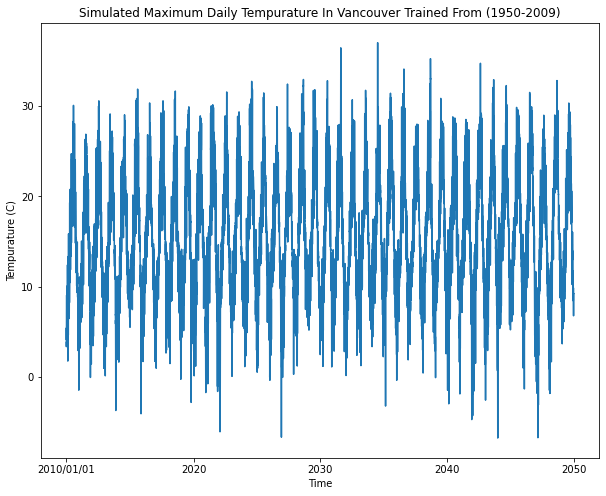

In [3]:
# Plot time vs temp just to check
plt.figure(figsize=(10, 8))
plt.plot(t_index, temp_data_s1)
plt.xticks([0,3658,7296,10944,14582], ['2010/01/01', '2020', '2030', '2040', '2050'])

plt.xlabel('Time')
plt.ylabel('Tempurature (C)')
plt.title('Simulated Maximum Daily Tempurature In Vancouver Trained From (1950-2009)')

plt.show()

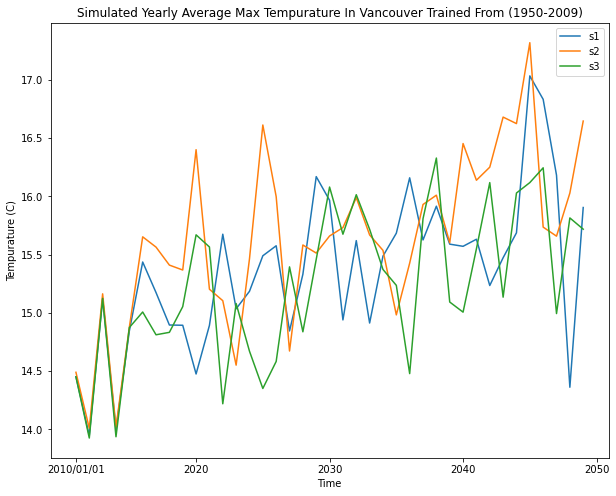

In [4]:
# Yearly Average
plt.figure(figsize=(10, 8))

# Scenario 1
ya_T = []
ystd_T = []
i = 0
while i < len(temp_data_s1)-365:
    ya_T.append(np.average([temp_data_s1[j] for j in range(i,i+365)]))
    ystd_T.append(np.std([temp_data_s1[j] for j in range(i,i+365)]))
    i += 365

T_avg = np.average(ya_T)
ystd_avg = np.average(ystd_T)
ya_t_index = [k for k in range(len(ya_T))]
plt.plot(ya_t_index, ya_T, label='s1')

# Scenario 2
ya_T = []
ystd_T = []
i = 0
while i < len(temp_data_s1)-365:
    ya_T.append(np.average([temp_data_s2[j] for j in range(i,i+365)]))
    ystd_T.append(np.std([temp_data_s2[j] for j in range(i,i+365)]))
    i += 365

T_avg = np.average(ya_T)
ystd_avg = np.average(ystd_T)
ya_t_index = [k for k in range(len(ya_T))]
plt.plot(ya_t_index, ya_T, label='s2')

# Scenario 3
ya_T = []
ystd_T = []
i = 0
while i < len(temp_data_s1)-365:
    ya_T.append(np.average([temp_data_s3[j] for j in range(i,i+365)]))
    ystd_T.append(np.std([temp_data_s3[j] for j in range(i,i+365)]))
    i += 365

T_avg = np.average(ya_T)
ystd_avg = np.average(ystd_T)
ya_t_index = [k for k in range(len(ya_T))]
plt.plot(ya_t_index, ya_T, label='s3')


plt.xticks([0,9,19,29,39], ['2010/01/01', '2020', '2030', '2040', '2050'])
plt.xlabel('Time')
plt.ylabel('Tempurature (C)')
plt.title('Simulated Yearly Average Max Tempurature In Vancouver Trained From (1950-2009)')
plt.legend()

plt.show()

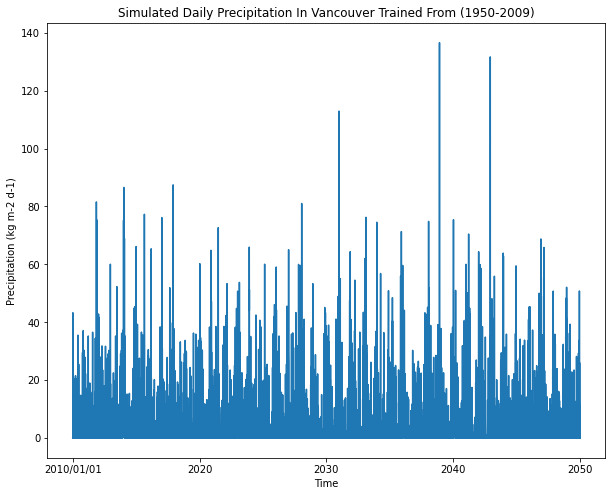

In [5]:
# Plot time vs precipitation just to check
plt.figure(figsize=(10, 8))
plt.plot(t_index, prec_data_s1)
plt.xticks([0,3658,7296,10944,14582], ['2010/01/01', '2020', '2030', '2040', '2050'])


plt.xlabel('Time')
plt.ylabel('Precipitation (kg m-2 d-1)')
plt.title('Simulated Daily Precipitation In Vancouver Trained From (1950-2009)')


plt.show()

In [6]:
# Probability density of set X at x
def P(X,x):
    X = np.histogram(X)
    for i in range(len(X[1])-1):
        if X[1][i] < x and x < X[1][i+1]:
            return X[0][i]/np.sum(X[0])
    
# Calculate entropy of prob. distribution generated from sample X with histogram list as input
def entropy(X_hist):
    H = 0 
    N = np.sum(X_hist)
    if N != 0:
        for nx in X_hist:
            if nx != 0:
                H -= nx*math.log(nx/N)/N
    return H

# Calculate entropy of joint PDF generated from samples X,Y with 2D histogram list as input
def joint_entropy(XY_hist):
    H = 0 
    N = np.sum(XY_hist)
    if N != 0:
        for row_i in XY_hist:
            for n_xy in row_i:
                if n_xy != 0:
                    H -= n_xy*math.log(n_xy/N)/N
    return H

# Mutual information from two samples X, Y
def mi(X, Y, bins):
    X_hist, X_edges = np.histogram(X, bins)
    Y_hist, Y_edges = np.histogram(Y, bins)
    XY_hist, XYx_edges, XYy_edges = np.histogram2d(X, Y, bins)
    MI =  entropy(X_hist) + entropy(Y_hist) - joint_entropy(XY_hist)
    return MI


# Time delay mutual information:
def tdmi(X, delay, bins):
    return mi(X[:len(X)-delay], X[delay:], bins)


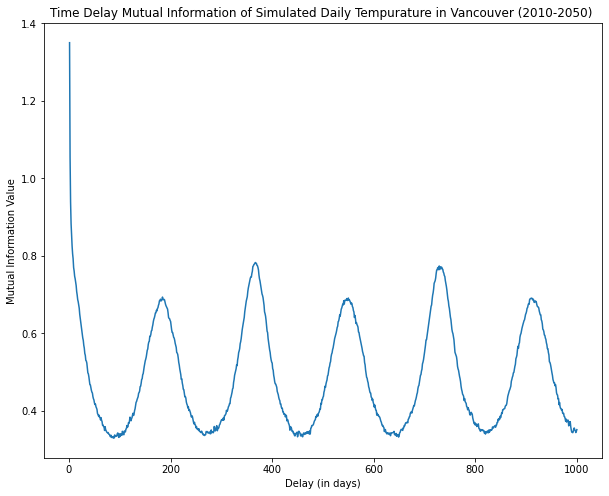

In [7]:
# Temp data analysis:
# Set bin number
bins = 100

# Delay
max_delay = 1000

D = [i + 1  for i in range(max_delay)]
TDMI = [tdmi(temp_data_s1, delay, bins) for delay in D]

plt.figure(figsize=(10,8))
plt.plot(D, TDMI)
plt.xlabel('Delay (in days)')
plt.ylabel('Mutual Information Value')
plt.title('Time Delay Mutual Information of Simulated Daily Tempurature in Vancouver (2010-2050) ')

plt.show()


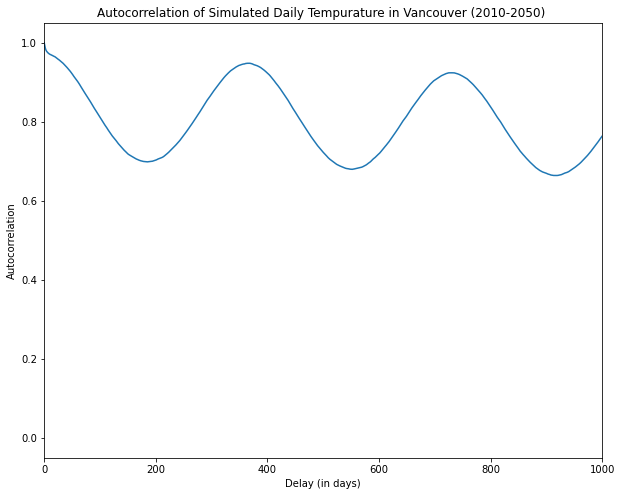

In [8]:
# Calculate the autocorrelation
Autocorr = np.correlate(temp_data_s1, temp_data_s1, mode='full')

# Normalization
Autocorr /= np.max(Autocorr)

# Generate the lag values for the x-axis
Lags = np.arange(-len(temp_data_s1) + 1, len(temp_data_s1))

# Plotting
plt.figure(figsize=(10,8))
plt.plot(Lags, Autocorr)
plt.xlim(0,1000)
plt.xlabel('Delay (in days)')
plt.ylabel('Autocorrelation')
plt.title('Autocorrelation of Simulated Daily Tempurature in Vancouver (2010-2050) ')

plt.show()


In [9]:
print('Mutual information Between Temperature And Precipitation')
print('Scenario 1: ', mi(temp_data_s1, prec_data_s1, bins))
print('Scenario 2: ', mi(temp_data_s2, prec_data_s2, bins))
print('Scenario 3: ', mi(temp_data_s3, prec_data_s3, bins))

Mutual information Between Temperature And Precipitation
Scenario 1:  0.1325726441609003
Scenario 2:  0.16378914722520133
Scenario 3:  0.14494353392700177


In [16]:
from scipy.spatial import distance
from scipy.stats import pearsonr, spearmanr
import dcor

dc1 = dcor.distance_correlation(np.array(temp_data_s1), np.array(prec_data_s1))
dc2 = dcor.distance_correlation(np.array(temp_data_s2), np.array(prec_data_s2))
dc3 = dcor.distance_correlation(np.array(temp_data_s3), np.array(prec_data_s3))

pearson_corr1, _ = pearsonr(np.array(temp_data_s1), np.array(prec_data_s1))
pearson_corr2, _ = pearsonr(np.array(temp_data_s2), np.array(prec_data_s2))
pearson_corr3, _ = pearsonr(np.array(temp_data_s3), np.array(prec_data_s3))


spearman_corr1, _ = spearmanr(np.array(temp_data_s1), np.array(prec_data_s1))
spearman_corr2, _ = spearmanr(np.array(temp_data_s2), np.array(prec_data_s2))
spearman_corr3, _ = spearmanr(np.array(temp_data_s3), np.array(prec_data_s3))


print("Distance Correlation")
print('Scenario 1: ', dc1)
print('Scenario 2: ', dc2)
print('Scenario 3: ', dc3)
print()
print("Pearson's Correlation")
print('Scenario 1: ', pearson_corr1)
print('Scenario 2: ', pearson_corr2)
print('Scenario 3: ', pearson_corr3)
print()
print("Spearman's Correlation ")
print('Scenario 1: ', spearman_corr1)
print('Scenario 2: ', spearman_corr2)
print('Scenario 3: ', spearman_corr3)

Distance Correlation
Scenario 1:  0.27261905773096046
Scenario 2:  0.30372356990866695
Scenario 3:  0.2785289916336257

Pearson's Correlation
Scenario 1:  -0.22333959358269667
Scenario 2:  -0.22746386197080795
Scenario 3:  -0.24474907044833538

Spearman's Correlation 
Scenario 1:  -0.29278829783629445
Scenario 2:  -0.3115243714891102
Scenario 3:  -0.2984585486390431


Phase Space Reconstruction of Rossler System:

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.integrate import solve_ivp


xyz_0 =  [1.0, 2.0, 3.0]


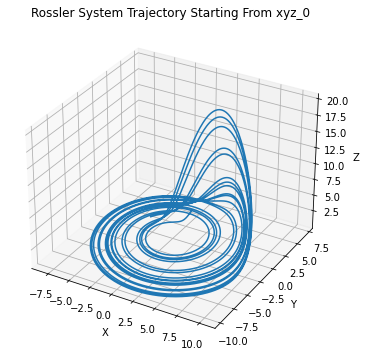

In [22]:
def rossler_system(x, y, z, a, b, c):
    dx = -y - z
    dy = x + a * y
    dz = b + z * (x - c)
    return dx, dy, dz

a = 0.2
b = 0.2
c = 5.0
dt = 0.01  # Time step
num_steps = 10000  # Number of steps

x = np.zeros(num_steps)
y = np.zeros(num_steps)
z = np.zeros(num_steps)

x[0], y[0], z[0] = [1, 2, 3]
print('xyz_0 = ', [x[0], y[0], z[0]])

for i in range(1, num_steps):
    dx, dy, dz = rossler_system(x[i-1], y[i-1], z[i-1], a, b, c)
    x[i] = x[i-1] + dx * dt
    y[i] = y[i-1] + dy * dt
    z[i] = z[i-1] + dz * dt

embedding_dim = 3  # Embedding dimension
time_delay = 10  # Time delay

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')
#fig figure(figsize=(6,6))
ax.plot3D(x, y, z)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Rossler System Trajectory Starting From xyz_0')
plt.show()


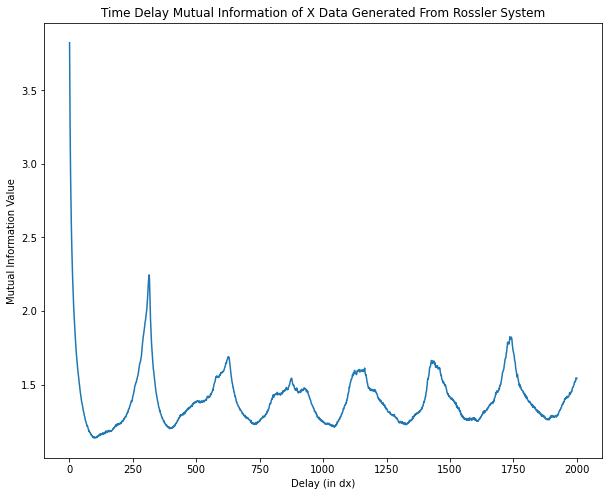

In [26]:
# Reconstruction from x data

bins = 100
# Delay
max_delay = round(num_steps/5)

D = [i + 1  for i in range(max_delay)]
TDMI = [tdmi(x, delay, bins) for delay in D]

plt.figure(figsize=(10,8))
plt.plot(D, TDMI)
plt.xlabel('Delay (in dx)')
plt.ylabel('Mutual Information Value')
plt.title('Time Delay Mutual Information of X Data Generated From Rossler System')

plt.show()

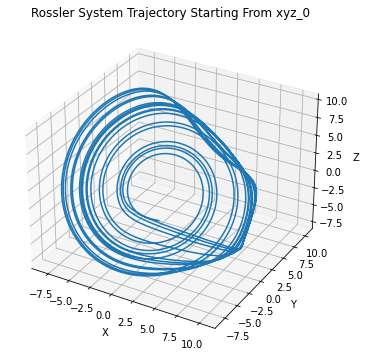

In [28]:
# Get optimal delay with min(TDMI)

min_delay_mi = [0,TDMI[0]]
for i in range(1, 250):
    if TDMI[i] < min_delay_mi[1]:
        min_delay_mi = [i,TDMI[i]]

        
optimal_delay = min_delay_mi[0]

#now set new y to x(t + optimal_delay) and z = x(t + 2*optimal_delay)

x_recon = x[:len(x)-2*optimal_delay]
y_recon = x[optimal_delay:len(x)-optimal_delay]
z_recon = x[2*optimal_delay:]

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')
#fig figure(figsize=(6,6))
ax.plot3D(x_recon, y_recon, z_recon)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Rossler System Trajectory Starting From xyz_0')
plt.show()
    

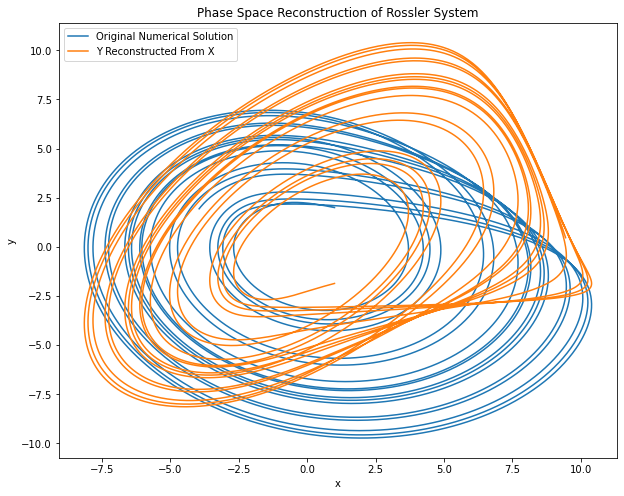

In [32]:
# More plotting

plt.figure(figsize=(10,8))
plt.plot(x,y, label='Original Numerical Solution')
plt.plot(x_recon,y_recon, label='Y Reconstructed From X')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Phase Space Reconstruction of Rossler System')
plt.legend()
plt.show()

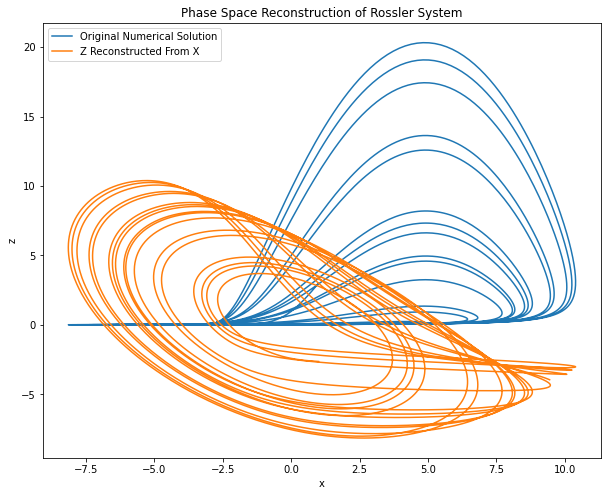

In [33]:
# More plotting

plt.figure(figsize=(10,8))
plt.plot(x,z, label='Original Numerical Solution')
plt.plot(x_recon,z_recon, label='Z Reconstructed From X')
plt.xlabel('x')
plt.ylabel('z')
plt.title('Phase Space Reconstruction of Rossler System')
plt.legend()
plt.show()